In [1]:
! pip install torchtext
! python -m spacy download en --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.2

# Libraries

In [34]:
import re
import tqdm
import spacy
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchtext.legacy.data import Field, BucketIterator,TabularDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords

In [35]:
STOPWORDS=stopwords.words('english')

# Parsing new dataset

In [3]:
def handle_apos(text):
    text = re.sub("'re", " are", text)
#     text = re.sub("'s", " is", text)
    text = re.sub("'m", " am", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'t", " not", text)
    return text

def handle_punctuation(text):
    text = text.replace(".", " ")
    text = text.replace(",", " ")
    text = text.replace("!", " ")
    text = text.replace("?", " ")
    text = text.replace(";", " ")
    text = text.replace(":", " ")
    text = text.replace("-", " ")
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    text = text.replace("[", " ")
    text = text.replace("]", " ")
    text = text.replace("{", " ")
    text = text.replace("}", " ")
    text = text.replace("/", " ")
    text = text.replace("\\", " ")
    text = text.replace("*", " ")
    text = text.replace("+", " ")
    text = text.replace("=", " ")
    text = text.replace("#", " ")
    text = text.replace("%", " ")
    text = text.replace("$", " ")
    text = text.replace("@", " ")
    text = text.replace("&", " ")
    text = text.replace("^", " ")
    text = text.replace("|", " ")
    text = text.replace("~", " ")
    text = text.replace("`", " ")
    text = text.replace("'", "")
    text = text.replace("\"", " ")
    text = text.replace("<", " ")
    text = text.replace(">", " ")
    text = text.replace("  ", " ")
    return text

In [4]:
import csv
csvreader=csv.reader(open("../input/domaintermextraction/raw_data.csv"))
header = []
header = next(csvreader)
header
dataset = []
label = []
arr=[16,16,16,16,16]
for row in csvreader:
    row=" ".join(row).split("\t")
    val=re.sub(' +', ' ', handle_punctuation(handle_apos(row[0].lower())))
    if(val=="business" and arr[0]>0):
        dataset.append(re.sub(' +', ' ', re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower())))))   
        label.append(val)
        arr[0]-=1
    if(val=="tech" and arr[1]>0):
        dataset.append(re.sub(' +', ' ', re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower())))))   
        label.append(val)
        arr[1]-=1
    if(val=="sport" and arr[2]>0):
        dataset.append(re.sub(' +', ' ', re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower())))))   
        label.append(val)
        arr[2]-=1
    if(val=="politics" and arr[3]>0):
        dataset.append(re.sub(' +', ' ', re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower())))))   
        label.append(val)
        arr[3]-=1
    if(val=="entertainment" and arr[4]>0):
        dataset.append(re.sub(' +', ' ', re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower())))))   
        label.append(val)
        arr[4]-=1     
  
train = pd.DataFrame({'content':dataset,'category':label})
train.to_csv("data.csv",index=False)



# Dataloaders

In [5]:
english=spacy.load('en_core_web_sm')

In [6]:
def en_tokenizer(text):
    return  [token.text for token in english.tokenizer(text)]

def lb_tokenizer(text):
    return  [token.text for token in english.tokenizer(text)]


en_field = Field(tokenize=en_tokenizer,lower=True)
lb_field = Field(tokenize=lb_tokenizer,lower=True)

In [7]:
train_data=TabularDataset.splits(path="../input/domaintermextraction",train="data.csv",format="csv",fields=[('content',en_field),('category',lb_field)],skip_header=True)[0]

In [8]:
batch_size=16
en_field.build_vocab(train_data,vectors='glove.6B.200d')
lb_field.build_vocab(train_data,specials_first=False )

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                               
100%|█████████▉| 399999/400000 [00:32<00:00, 12454.87it/s]


In [9]:
train_iter,_,_ = BucketIterator.splits((train_data,train_data,train_data), batch_size = batch_size,sort_within_batch=True,sort_key=lambda x: len(x.content),device = device)

In [10]:
# dataset
unk_word=[]

# frequency
freq_dict = dict()
unk_freq_dict = dict()



for line in dataset:
    for word in line.split():
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word]+= 1
freq_dict["<pad>"]=2*len(dataset)


# remove frequency less than 5 
kill_less = 5
remove_keys = set()
for key, value in freq_dict.items():
    if value<kill_less:
        remove_keys.add(key)
        
for key in remove_keys:
    unk_word.append(key)    
    unk_freq_dict[key]=freq_dict[key]

    resp = freq_dict.pop(key, None)
    if resp is None:
        print("Logical Error")    

        
# dictionaries
counter = 1
index_dict = dict()
index_dict["<pad>"] = 0
for key in freq_dict.keys():
    if key!="<pad>":
        index_dict[key] = counter
        counter+=1

word_dict = dict()
word_dict[0] = "<pad>"
for key, value in index_dict.items():
    word_dict[value] = key 


# vocab size
VOCAB_SIZE = len(index_dict)

In [11]:
weights=[]
value=[]
for x in unk_word:
    if x in en_field.vocab.itos:
        weights.append(unk_freq_dict[x])
        value.append(np.array(en_field.vocab.vectors[en_field.vocab.stoi[x]]))
value=np.array(value)
weights=np.array(weights)

In [12]:
unk_vect=np.average(value, axis=0, weights=weights, returned=False)
# unk_vect

In [13]:
en_field.vocab.vectors[en_field.vocab.stoi["<unk>"]]=torch.Tensor(unk_vect)

In [14]:
en_field.vocab.vectors.shape

torch.Size([29003, 200])

In [15]:
len(en_field.vocab.stoi)

29003

In [16]:
lb_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f9cadcb6d10>>,
            {'sport': 0,
             'politics': 1,
             'business': 2,
             'entertainment': 3,
             'tech': 4,
             '<unk>': 5,
             '<pad>': 6})

## save variables

In [17]:
import pickle 
output_dict={}
output_dict["en_field"]=en_field
output_dict["lb_field"]=lb_field
output_dict["embedding"]=en_field.vocab.vectors

pickle.dump(output_dict,open("./pandora.pkl","wb"))

### load variables

In [18]:
import pickle
output_dict = pickle.load(open("../input/domaintermextraction/pandora.pkl","rb")) 

In [19]:
en_field.vocab.vectors[en_field.vocab.stoi["<unk>"]]=output_dict["en_field"].vocab.vectors[en_field.vocab.stoi["<unk>"]]

In [20]:
en_field.vocab.vectors[en_field.vocab.stoi["<unk>"]]

tensor([ 0.0553,  0.0020,  0.0095,  0.0538,  0.0555,  0.0419,  0.0023,  0.0915,
        -0.0083,  0.0630,  0.0553,  0.0627,  0.0474, -0.0090, -0.0811, -0.0030,
        -0.0227,  0.0213, -0.0255, -0.0286,  0.0153,  0.1772,  0.0121, -0.0373,
        -0.0028, -0.0688, -0.0309, -0.0383, -0.0102,  0.0253, -0.0258,  0.0277,
         0.0134,  0.0735, -0.0249, -0.0543, -0.0423, -0.0383, -0.0374,  0.0554,
         0.0643, -0.0051,  0.0228,  0.0392,  0.0254,  0.0184, -0.0203,  0.0486,
        -0.0235,  0.0066, -0.0314, -0.0101, -0.0079,  0.0739,  0.0305, -0.0003,
        -0.0092,  0.0158, -0.0339, -0.0276,  0.0214, -0.0150,  0.0083, -0.0030,
         0.0271,  0.0671, -0.0105, -0.0391, -0.0666, -0.0304,  0.0276, -0.0316,
        -0.0035,  0.0518, -0.0797, -0.0330, -0.0627, -0.0058,  0.0012, -0.0365,
         0.0313, -0.0162,  0.0459, -0.0255,  0.0284, -0.0177,  0.0336,  0.0117,
        -0.0113, -0.0531,  0.0341, -0.0297,  0.0500, -0.0009, -0.0363,  0.0241,
         0.0287, -0.0119,  0.0271, -0.01

In [21]:
del  header,dataset,freq_dict,unk_freq_dict,word_dict,index_dict,weights,value,csvreader

In [22]:
torch.cuda.empty_cache()

# Architecture

In [23]:
class LSTM_attention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim_1, batch_size):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((batch_size,2*hidden_dim_1, 1)), requires_grad = True)
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_layer.weight.data.copy_(en_field.vocab.vectors)
        self.embedding_layer.weight.requires_grad = False ## freeze embeddings
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim_1, num_layers=5, batch_first=True, bidirectional=True)
        self.fc_layer1 = nn.Linear(2*hidden_dim_1, 5)    
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_sent):
        input_emb = self.embedding_layer(input_sent)
        sent_lstm_out,hid = self.lstm_layer(input_emb)
        M = torch.tanh(sent_lstm_out)
        mul = torch.matmul(M, self.weight)
        alpha = self.softmax(mul)
        r = torch.matmul(torch.transpose(sent_lstm_out, 1, 2), alpha)
        output = self.fc_layer1(r.reshape((r.shape[0], r.shape[1])))
        return output, alpha

In [24]:
! mkdir ./uni_gram

In [25]:
lstm_model = LSTM_attention(en_field.vocab.vectors.shape[0], en_field.vocab.vectors.shape[1], 300, batch_size).double().cuda()
optimizer = optim.SGD(lstm_model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()
num_epochs = 100
a = []
best_loss=float("inf")
best_accuracy=0
state={}
acc_arr=[]
loss_arr=[]
for epoch in range(num_epochs):
    current_loss = 0
    accuracy=0
    count=0
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_input = x.content.T.cuda()
            out, alpha = lstm_model(x_input)
            y_label =  x.category.T.reshape(x.category.T.shape[0]).cuda()
            accuracy_dash=accuracy_score(list(np.argmax(out.cpu().data.numpy(),axis=1)),list(y_label.cpu().data.numpy()))
            accuracy+=accuracy_dash
            count+=1
            loss = loss_function(out,y_label)
            current_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    accuracy=accuracy/count
    current_loss=current_loss/count
    acc_arr.append(accuracy)
    loss_arr.append(current_loss)
    print("Epoch : ",epoch)
    print("Accuracy : ",accuracy)
    print("Loss : ",current_loss)
    if(best_accuracy<accuracy or accuracy>0.99):
        if accuracy - best_accuracy > 0.01 or accuracy > 0.95:
            torch.save(lstm_model,"./uni_gram/model_"+str(epoch)+"_"+str(accuracy)+"_"+str(current_loss)+".pt")
        best_accuracy=accuracy

 46%|████▌     | 47/102 [00:21<00:25,  2.18it/s]


KeyboardInterrupt: 

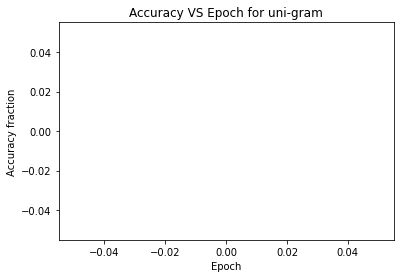

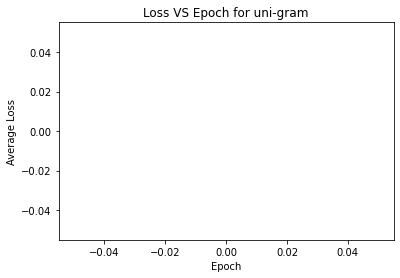

In [26]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for uni-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.show()
plt.plot(loss_arr)
plt.title("Loss VS Epoch for uni-gram")
plt.ylabel("Average Loss")
plt.xlabel("Epoch")
plt.show()

In [27]:
torch.save(lstm_model,"./uni_gram/final_model")

In [28]:
print(loss_arr)

[]


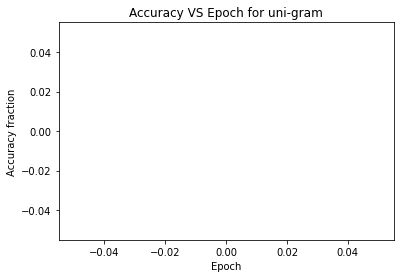

In [29]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for uni-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.savefig('./uni_gram/acc.jpg')

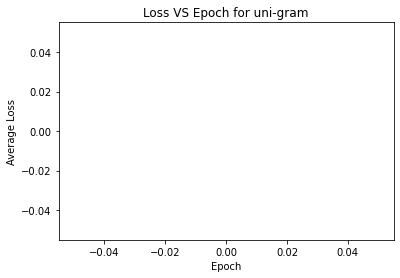

In [30]:
plt.plot(loss_arr)
plt.title("Loss VS Epoch for uni-gram")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig('./uni_gram/loss.jpg')


In [31]:
import shutil
shutil.make_archive("unigram", 'zip', "./uni_gram")

'/kaggle/working/unigram.zip'

In [32]:
import os
os.chdir(r'/kaggle/working/')
from IPython.display import FileLink
FileLink(r'./unigram.zip')

/kaggle/working/unigram.zip

### Generating Keywords

In [36]:
key_word_scores = {}
r = 50
lstm_model.eval()
with torch.no_grad():
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_t = x.content.T
            label = np.array(x.category.T.cpu())
            label = label.reshape((label.shape[0]))
            out, alpha = lstm_model(x_t)
            alpha = alpha.cpu()
            for j in range(alpha.shape[0]):
                scores = []
                words = []
                ind = 0
                for k in range(alpha.shape[1]):
                    scores.append([alpha[j][k], en_field.vocab.itos[int(x_t[j][k])]])
                scores.sort(key=lambda y:y[0], reverse=True)
                while ind < alpha.shape[1]:
                    k = scores[ind]
                    if k[1] not in STOPWORDS and k[1] != "<pad>" and k[1] != "<unk>" and k[1] != " ":
                        words.append([k[1], k[0]])
                    ind += 1
                    if len(words) == r:
                        break
                if lb_field.vocab.itos[label[j]] not in key_word_scores.keys():
                    key_word_scores[lb_field.vocab.itos[label[j]]] = []
                key_word_scores[lb_field.vocab.itos[label[j]]].append(words)
pickle.dump(key_word_scores, open("unigram_keywords.pkl","wb"))

  5%|▍         | 5/102 [00:03<00:59,  1.63it/s]


KeyboardInterrupt: 